#TFM - Análisis de la evolución de noticias falsas en Twitter

##Fase 02 - Texto a Números

En esta fase trataremos de procesar el texto de los tweets y pasarlos por el modelo para adquirir los Embeddings. 
También trataremos de localizar el tweet más antiguo que hable de esta noticia falsa.


##Fuentes
###Sentence-BERT
- [Sentence Embeddings with BERT & XLNet](https://pythonrepo.com/repo/UKPLab-sentence-transformers-python-natural-language-processing)
- [Quickstart Sentence-BERT](https://www.sbert.net/docs/quickstart.html)
- [Pretrained Models](https://www.sbert.net/docs/pretrained_models.html)

###BERT Analisis Twitter
- [How I used Bidirectional Encoder Representations from Transformers (BERT) to Analyze Twitter Data](https://analyticsindiamag.com/how-i-used-bidirectional-encoder-representations-from-transformers-bert-to-analyze-twitter-data/)
- [Hands-On Guide to Download, Analyze and Visualize Twitter Data](https://analyticsindiamag.com/hands-on-guide-to-download-analyze-and-visualize-twitter-data/)
- [Guide To Pysentimiento Toolkit | Text Classification Using Transformers](https://analyticsindiamag.com/guide-to-pysentimiento-toolkit-text-classification-using-transformers)

###Sentence-bert model spanish texts
- [Multi-Lingual Models](https://www.sbert.net/docs/pretrained_models.html)
- [BETO: Spanish BERT](https://medium.com/dair-ai/beto-spanish-bert-420e4860d2c6)
- [BETO: Spanish BERT on GitHub](https://github.com/dccuchile/beto)

@inproceedings{CaneteCFP2020,
  title={Spanish Pre-Trained BERT Model and Evaluation Data},
  author={Cañete, José and Chaperon, Gabriel and Fuentes, Rodrigo and Ho, Jou-Hui and Kang, Hojin and Pérez, Jorge},
  booktitle={PML4DC at ICLR 2020},
  year={2020}
}

###Calculo de distancias
- [scipy.spatial.distance.cosine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html)
- [Cosine Similarity – Understanding the math and how it works (with python codes)](https://www.machinelearningplus.com/nlp/cosine-similarity/)
- [Document Similarity] (https://shravan-kuchkula.github.io/document_similarity/#)
- [Semantic Textual Similarity](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)

###CSV
- [CSV File Reading and Writing](https://docs.python.org/3/library/csv.html)

###Helps on development
- https://stackoverflow.com/questions/62710872/how-to-store-word-vector-embeddings
- https://stackoverflow.com/questions/66537949/convert-twitter-new-date-format-to-date-time-y-m-d-hms
- https://stackoverflow.com/questions/8200342/removing-duplicate-strings-from-a-list-in-python



In [ ]:
#################################################
# Needed Installations
#################################################
# install the sentence-transformers
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 2.9 MB 17.6 MB/s 
     |████████████████████████████████| 1.2 MB 55.8 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 
     |████████████████████████████████| 636 kB 61.0 MB/s 
     |████████████████████████████████| 3.3 MB 18.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=c391176c9343b89fd5cac8dc1eff632690797791a668c9a6074c870c534105f9
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#################################################
# Importing Libraries
#################################################
# Importing Sentence Transformers Library to get model after
from sentence_transformers import SentenceTransformer, util

# Needed to create/load csv file with twits
import csv

# Numpy (here we go to use it for store/load embeddings on cloud)
import numpy as np

# notice we are importing datetime from datetime (we are importing the `datetime` type from the module datetime
from datetime import datetime

In [ ]:
######################################################
# Mount google drive and use folder of data
######################################################
from google.colab import drive
drive.mount('/content/drive/')
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/'


Mounted at /content/drive/


In [ ]:
#################################################################
# Method that replace and remove Unicode chars
# https://en.wikipedia.org/wiki/List_of_Unicode_characters
#################################################################
def UnicodeFilter(var):
    temp = var
    temp = temp.replace(chr(0x0015), "'")
    temp = temp.replace(chr(0x2026), "")
    temp = temp.replace(chr(0x2015), " ")

    # Remove emojis and all that shit
    for x in range(127381, 129305):
        temp = temp.replace(chr(x), "")
    return str(temp)
#end_def

#DEBUG code
##print(chr(0x0015))
##print(chr(0x2026))
##print(chr(0x2019)) 
##for x in range(127381, 129305):
##    print(chr(x))

In [ ]:
#################################################
# Method that  Load stored twits from CSV and
# makes a little processed of data in order to 
# get tweets text normalized for spanish language
#
# TODO: can be improved
#################################################
def preprocess_tweets_text(csv_file_fullname_var):
    # Load previous stored twits on csv
    with open(csv_file_fullname_var, newline='') as f:
        reader = csv.reader(f)
        sentences = list(reader)    
    #end_with

    # little tweets traitment
    length = len(sentences)
    del sentences[length - 1]
    del sentences[0]#remove csv header
    length = len(sentences)

    # Init list
    sentences_processed = [''] * length

    # Iterating the index
    # same as 'for i in range(len(list))'
    for i in range(0, length):
        ##print(i)
        ##print(sentences[i])
        try:
          sentences_processed[i] = UnicodeFilter(sentences[i][0])
          ##print(sentences_processed[i])
        except:
          print("An exception occurred")     
    #end_for

    #Removing duplicate tweets
    sentences_processed_v2 = list(set(sentences_processed))

    return sentences_processed_v2
#end_def


In [ ]:
#################################################
# Method that  Load stored twits from CSV try
# to get older tweet
#
# TODO: can be improved
#################################################
def get_older_tweet(csv_file_fullname_var):

    #
    dt_current_creation_date = datetime.today()

    #index of creation date on our CSV
    creation_date_index = 4

    # Init aux var to contain older date
    dt_older_creation_date = datetime.now()

    #
    older_tweet = []

    # Load previous stored twits on csv
    with open(csv_file_fullname_var, newline='') as f:
        reader = csv.reader(f)
        lines = list(reader)    
    #end_with        

    del lines[0]#remove csv header
    length = len(lines)

    for i in range(0, length):
      s_creation_date = lines[i][creation_date_index]
      ##print(s_creation_date)        

      # convert the string to a datetime object from pattern Sat Sep 25 16:35:17 +0000 2021
      ##dt_current_creation_date = datetime.strftime(datetime.strptime(s_creation_date,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')
      dt_current_creation_date = datetime.strptime(s_creation_date, '%a %b %d %H:%M:%S +0000 %Y')
      ##print((dt_current_creation_date))

      # compare the dates and append if it meets the criteria
      if dt_current_creation_date <= dt_older_creation_date:
          ##print(s_creation_date)
          dt_older_creation_date = dt_current_creation_date
          older_tweet = lines[i]
      elif not older_tweet:
          ##print("List is empty")
          older_tweet = lines[i]
      #end_if

    #end_for

    return older_tweet
#end_def    


In [ ]:
#################################################
# Tweets text load and pre-procesing
#################################################
# Names of files
json_file_fullname = BASE_FOLDER+'20210922_twits_megatsunami.json'
csv_file_fullname = BASE_FOLDER+'20210922_twits_megatsunami.csv'
csv_text_file_fullname = BASE_FOLDER+'20210922_only_text_twits_megatsunami.csv'

# Pre-process text
preproc_txt = preprocess_tweets_text(csv_text_file_fullname)
print(len(preproc_txt))
print(preproc_txt)

print('\n  ------------- \n')

# Try to find the older tweet that stores
###my_older_tweet = get_older_tweet(BASE_FOLDER+'20210922_twits_megatsunami.csv')
###print('El tweet más antiguo de los almacenados es: ')
###print("\n".join(my_older_tweet))
###print('puedes buscar en el csv con todos los datos a ojo la noticia falsa partiendo de la indicada ')


188
['No, el volcán de La Palma no va a provocar un megatsunami que arrase Nueva York https://t.co/3SIoQYH1hC a través de @ABC_Ciencia', 'RT @NoticieroMAD: VOLCÁN de LA PALMA: El BULO del MEGATSUNAMI | RTVE Noticias https://t.co/jpRwrRti70 #TELEVISIÓN #Noticias', 'No, el volcán de La Palma no va a provocar un megatsunami que arrase Nueva York  https://t.co/oaPEWygivZ a través de @ABC_Ciencia', 'No, el volcán de La Palma no va a provocar un megatsunami que arrase Nueva York\n\n#eltorotv #lapalma #tsunami #nuevayork https://t.co/sFO1oyh0Lj', '@capitanbolano No pasará nada. https://t.co/2smNLj4sZL', "RT @rtve: El bulo viral sobre el 'megatsunami' por la erupción en La Palma  https://t.co/LOOxkNPYLT", 'RT @FMontecruz: Vamos a ver...veo tuits de algunas personas que hablan de la teoría del megatsunami. La situación ya es bastante terrible c', 'No, el volcán de La Palma no va provocar un megatsunami que arrase Nueva\xa0York https://t.co/SkHYlEg145', 'RT @laprovincia_es: Los científicos arrem

In [ ]:
#################################################
# Using Sentence Transformers
#################################################

#load model
##model = SentenceTransformer('paraphrase-distilroberta-base-v1')
##model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#################################################
# Using BERT Sentence
#################################################

#DEBUG code
##sentences_test = ['This framework generates embeddings for each input sentence',
##    'Sentences are passed as a list of string.', 
##    'The quick brown fox jumps over the lazy dog.']
##print(type(sentences_test))
##print(type(sentences_test) == type(preproc_txt))

#Compute embeddings
# Provide twits to the model
sentence_embeddings = model.encode(preproc_txt)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [ ]:
#################################################
# Review the list of numpy arrays with the embeddings with his tweet
# We must enable this through variable write_on_file setting this to true
#################################################

write_on_file = False

if write_on_file:
  with open(BASE_FOLDER+'20210930_embedings_with_sentences.txt', 'a') as the_file:
    
    for sentence, embedding in zip(preproc_txt, sentence_embeddings):
        ##the_file.write('Hello\n')
        print("Sentence:", sentence, file=the_file)
        print("Embedding:", embedding, file=the_file)
        print("", file=the_file)
        ##print("Sentence:", sentence)
        ##print("Embedding:", embedding)
        ##print("")

    the_file.close()
else:
  print('!ATENCIÓN¡ Fichero no escrito...')   
#end_if


In [ ]:
#################################################
# Store embeddings on DRIVE in order to could use
# independent of the previous process
#################################################
store_in_drive = False

if store_in_drive:
  embeddings_file_fullname = BASE_FOLDER+'embeddings.npy'

  ##all_embeddings = np.array(embedding)
  np.save(embeddings_file_fullname, sentence_embeddings)

In [ ]:
#################################################
# Get by hand my selected fake news tweet
#################################################
my_selected_tweet = 'RT @Finanzas_Times: Cuando la ladera del volcán se desprenda y se hunda en el mar, una ola de 900 metros de altura devastará algunas partes'#it is more longer
my_selected_tweet_full = ['']

need_get_full_text = False

if need_get_full_text:
    # Point i to the last element in list
    i = len(preproc_txt) - 1 
    # Iterate till 1st element and keep on decrementing i
    while i >= 0 :
        #print(preproc_txt[i])
        if my_selected_tweet in preproc_txt[i]:
          print(preproc_txt[i])
          my_selected_tweet_full = preproc_txt[i]
          break
        #end_if
        i -= 1
    #end_while
else:
  my_selected_tweet_full[0] = my_selected_tweet
#end_if

print(my_selected_tweet_full)

#Compute embeddings
# Provide twits to the model
my_selected_tweet_embedding = model.encode(my_selected_tweet_full)
#print(my_selected_tweet_embedding)


['RT @Finanzas_Times: Cuando la ladera del volcán se desprenda y se hunda en el mar, una ola de 900 metros de altura devastará algunas partes']


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


##Fase 03 - Cálculo de distancias

En esta fase trataremos de utilizar los embeddings almacenados para calcular las similitud entre los textos de los tweets utilizando la distancia por coseno.


###Distancia Coseno

Un enfoque comúnmente utilizado para hacer coincidir documentos similares se basa en contar el número máximo de palabras comunes entre los documentos, enfoque a todas luces defectuoso, ya que a medida que aumenta el tamaño del documento, la cantidad de palabras comunes tiende a aumentar incluso si los documentos hablan de diferentes temas.

In [ ]:
#################################################
# COSEIN distances for 1 to n
# Our objective is to quantitatively estimate the 
# similarity between selected tweets and all each 
# others
#################################################

sentences = preproc_txt
embeddings = sentence_embeddings

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(my_selected_tweet_embedding, embeddings)
##print(cosine_scores)

#################################################
# Write output in file, in order to see data better
write_on_file = False

if write_on_file:
  with open(BASE_FOLDER+'20210930_tweets_with_scores.txt', 'a') as the_file:

    #Output the pairs with their score
    for i in range(len(sentences)):
        #print('\n\n --- Tweet ',i,' ---')
        #print("{} \t\t {} \t\t \n Score: {:.4f}".format(my_selected_tweet_embedding[0], sentences[i], cosine_scores[0][i]))
        print('\n --- Tweet ',i,' ---', file=the_file)
        #print("{} \n {} \n Score: {:.4f}".format(my_selected_tweet_embedding[0], sentences[i], cosine_scores[0][i]), file=the_file)
        print("Tweet Seleccionado: {} \nTweet Comparado: {} \n    Similitud: {:.4f}".format(my_selected_tweet_full[0], sentences[i], cosine_scores[0][i]), file=the_file)
    #end_for

  the_file.close()   
else:
  print('!ATENCIÓN¡ Fichero no escrito...')   
#end_if

Fichero no escrito...


In [ ]:
#################################################
# COSEIN distances for n to n
# Our objective is to quantitatively estimate the 
# similarity between all stored tweets
#################################################

sentences = preproc_txt
embeddings = sentence_embeddings

labels = []

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})
        labels += 'tweet_'+str(i)+str(j)

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
#print(pairs)

#for pair in pairs[0:10]:
#    i, j = pair['index']
#    ##print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))
#    name = '(tweet_'+str(i)+', tweet_'+str(j)+')'
#    #print(name)    
#    df = pd.DataFrame({'pair': sentences, 'similarity': pair['score']})

   

In [ ]:
import IPython
js_code = '''
document.querySelector("#output-area").appendChild(document.createTextNode("hello world!"));
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

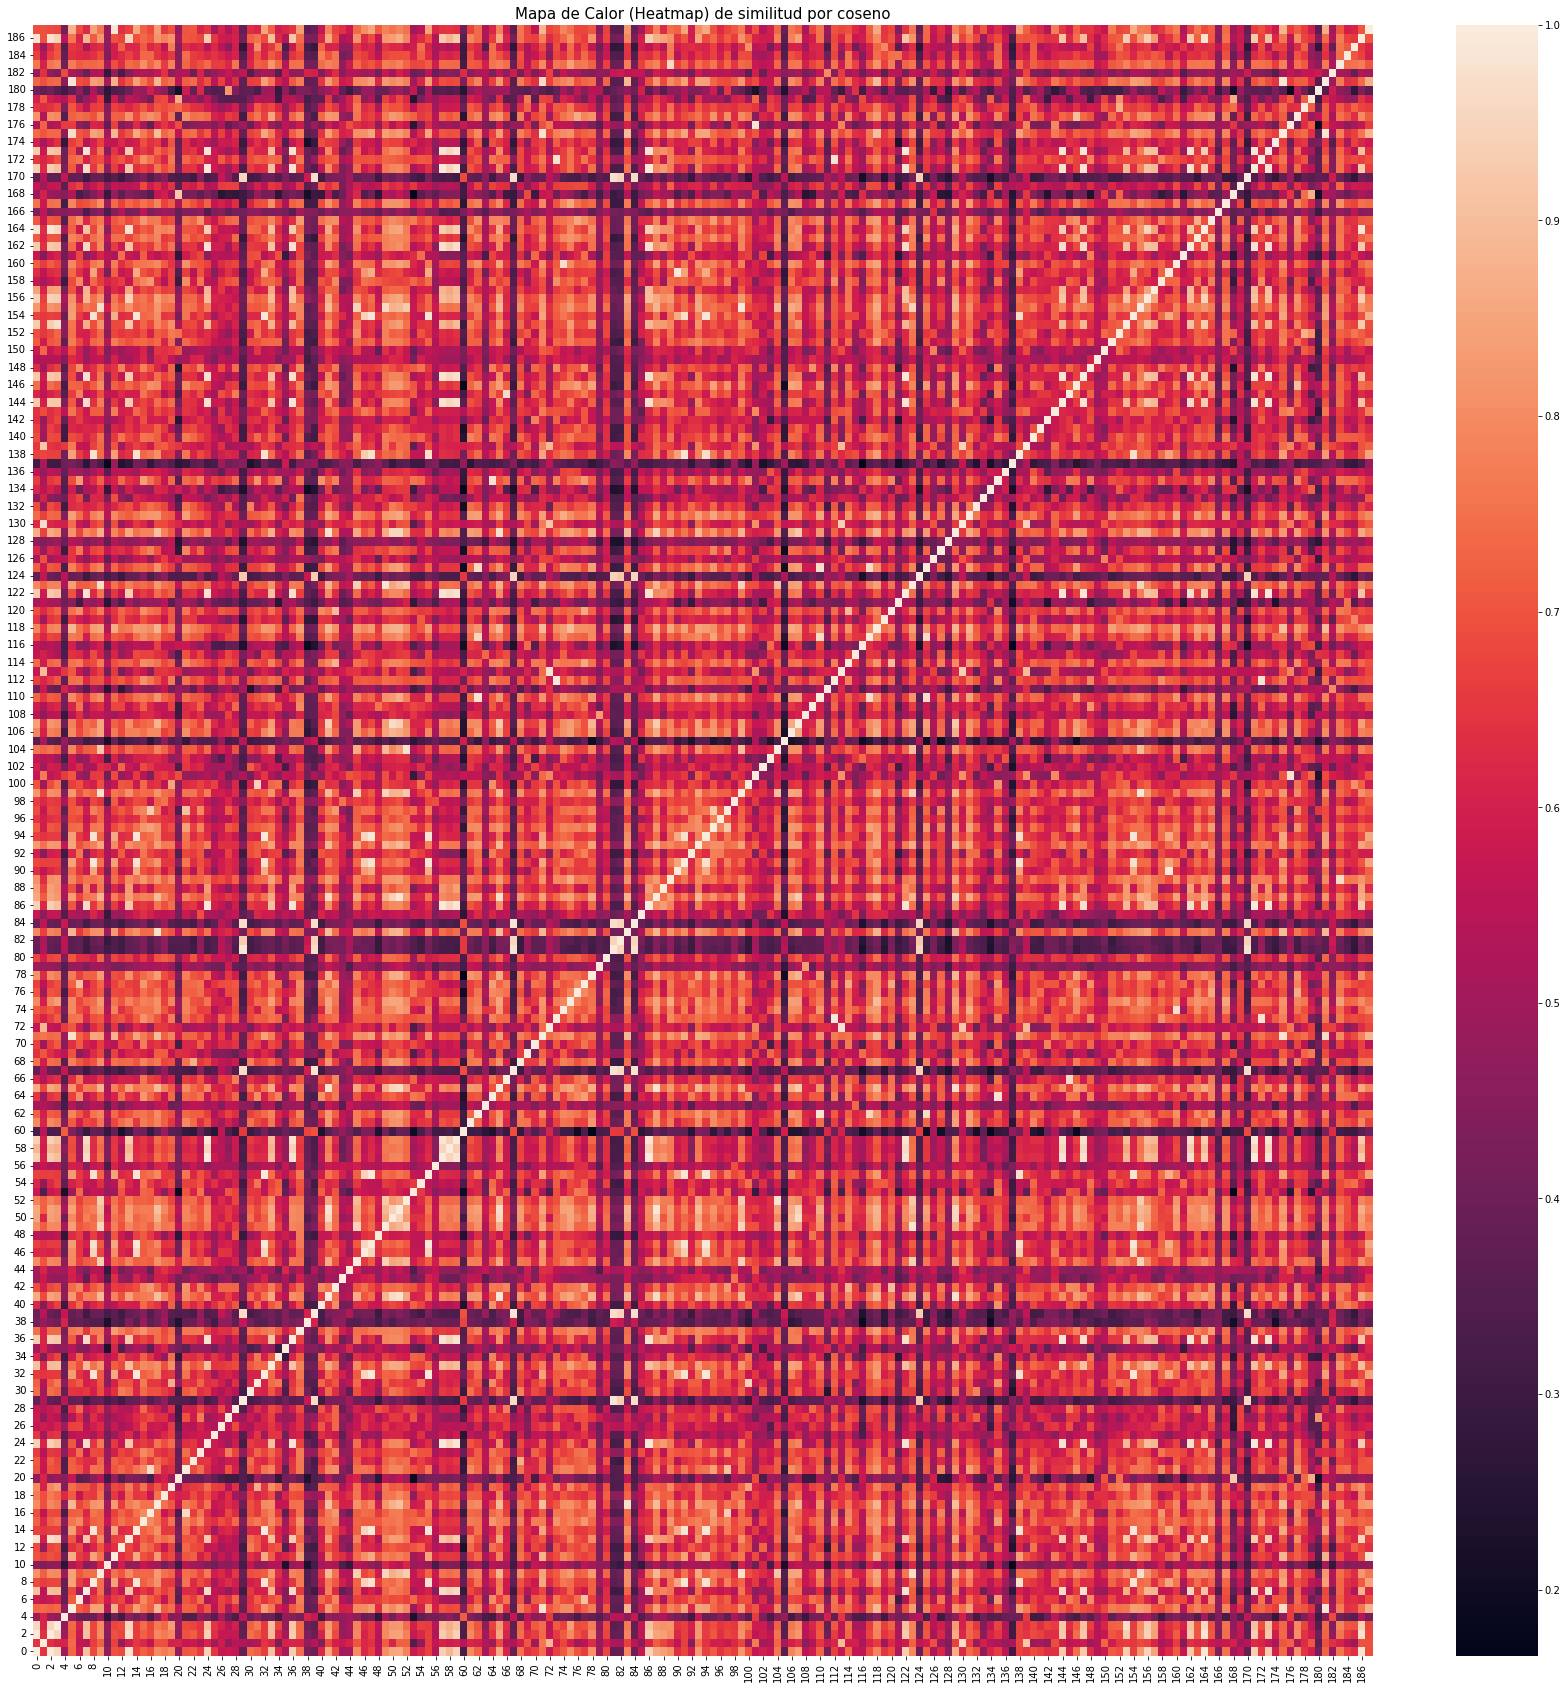

In [ ]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(cosine_scores)
ax.set_title("Mapa de Calor (Heatmap) de similitud por coseno").set_fontsize(15)
ax.invert_yaxis()
##plt.xticks(range(len_2_range), labels, rotation=90);
plt.show()

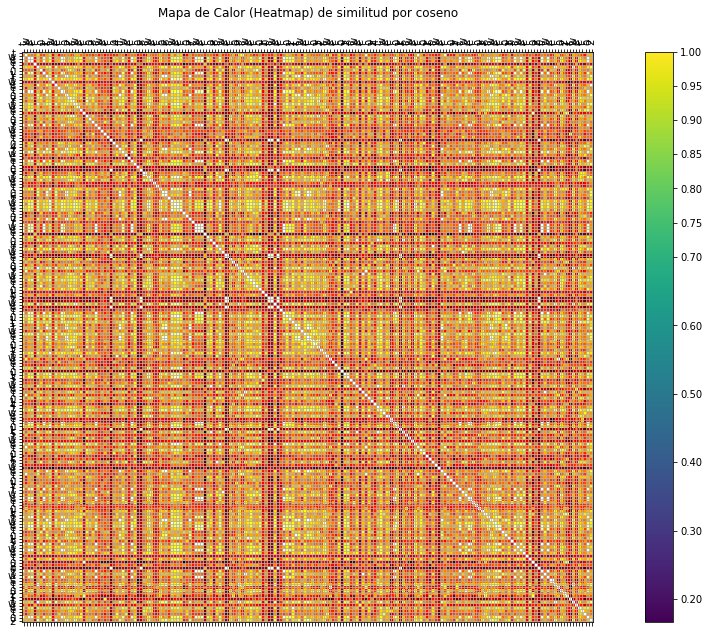

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

len_2_range = len(cosine_scores)

fig, ax = plt.subplots(figsize=(30,30))
cax = ax.matshow(cosine_scores, interpolation='nearest')
ax.grid(True)

plt.title('Mapa de Calor (Heatmap) de similitud por coseno')
##plt.xticks(range(len(cosine_scores)), labels, rotation=90);
##plt.yticks(range(len(cosine_scores)), labels);
plt.xticks(range(len_2_range), labels, rotation=90);
plt.yticks(range(len_2_range), labels);

fig.set_size_inches(18.5, 10.5)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])

plt.imshow(cosine_scores, cmap='hot', interpolation='nearest')
plt.show()

